In [ ]:
"""
Made on July 10th, 2019
@author: Theodore Pena
@contact: theodore.pena@tufts.edu
"""
print()

# Setup and imports

In [2]:
import sys
print("sys version: {}".format(sys.version))
# This project is entirely in python 3.7

import matplotlib
import matplotlib.pyplot as plt
%matplotlib qt 
# If you don't have an X server, line 7 might crash your kernel. Try '%matplotlib inline' instead.

import numpy as np
print("numpy version: {}".format(np.__version__))

import pandas as pd
print("pandas version: {}".format(pd.__version__))

from tqdm import tqdm
# This gives for loops progress bars.

import random
# This helps choosing random numbers from our arrays

from IPython.core.display import display, HTML
# An alternate, cleaner take on the jupyter workspace
display(HTML("<style>.container { width:100% !important; }</style>"))

sys version: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy version: 1.16.2
pandas version: 0.24.2


In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

# Data extraction

In [4]:
# Variables
brightest_percent = 1 # Out of the entire sample, the program will choose the brightest (brightest_percent)%. Setting this to 100 means that we choose randomly from the whole sample. 
num_random_points = 1000 # This is the number of points that are randomly choosen from the light curve
t_max = 1000 # The last number in the sequence 5, 10, ..., 1000 (the point furthest from each chosen point)
t_step = 5 # The diffrence between two points in the sequence 5, 10, ...
length_curve = 2**24 # Number of points in the curve
num_curves = 20 # Number of curves we're examining

In [5]:
# Load the data
default_curves = []
for i in tqdm(range(num_curves + 1)):
    
    if i == 0:
        continue # for some reason the results files start at 1 and not 0
        
    _er_curve = np.zeros(length_curve, dtype=float)
    _er_curve = np.fromfile('/home/tpena01/AGN_variability_project/Simulations/light_curves/default_params/results_Default_curve_{}.bin'.format(str(i)))
    default_curves.append(_er_curve)

default_curves = np.array(default_curves)

100%|██████████| 21/21 [00:08<00:00,  2.25it/s]


In [6]:
# Cut out the last t_max points
cut_curves = np.zeros((np.array(list(default_curves.shape)) - np.array([0, t_max])))
for i in tqdm(range(num_curves)):
    cut_curves[i, :] = default_curves[i, :-t_max]

100%|██████████| 20/20 [00:02<00:00,  6.40it/s]


In [7]:
# Select the brightest (brightest_percent)% of points
num_brightest = int(np.floor((cut_curves[0].shape[0] * (brightest_percent/100))))

indices = []
for i in tqdm(range(cut_curves.shape[0])):
    indices.append(np.argpartition(cut_curves[i, :], -num_brightest)[-num_brightest:])

indices = np.array(indices)

100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


In [8]:
# Randomly sample from the chosen indices

chosen_indices = []
for brightest_points_in_curve in tqdm(indices):
    chosen_indices.append(random.sample(list(brightest_points_in_curve), num_random_points))

chosen_indices = np.array(chosen_indices, dtype=int)

100%|██████████| 20/20 [00:00<00:00, 104.01it/s]


In [9]:
# Select all our points
t_examine = np.arange(0, t_max+1, t_step)

master_array = np.zeros(t_examine.shape, dtype=int)

for i in tqdm(range(cut_curves.shape[0])):
    master_array = np.vstack((default_curves[i][(np.reshape(chosen_indices[i, :], (len(chosen_indices[i, :]), 1)) + t_examine).astype(int)], master_array))

master_array = np.delete(master_array, -1, 0)

for i in tqdm(range(master_array.shape[1])):
    master_array[:, i] = master_array[:, i] - master_array[0, i]

100%|██████████| 201/201 [00:00<00:00, 3423.77it/s]


In [10]:
# Find our trends
means = []
stands = []

for i in tqdm(range(master_array.shape[1])):
    means.append(np.mean(master_array[:, i]))
    stands.append(np.std(master_array[:, i]))

means = np.array(means)
stands = np.array(stands)

100%|██████████| 201/201 [00:00<00:00, 2080.89it/s]


# Graphs

/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


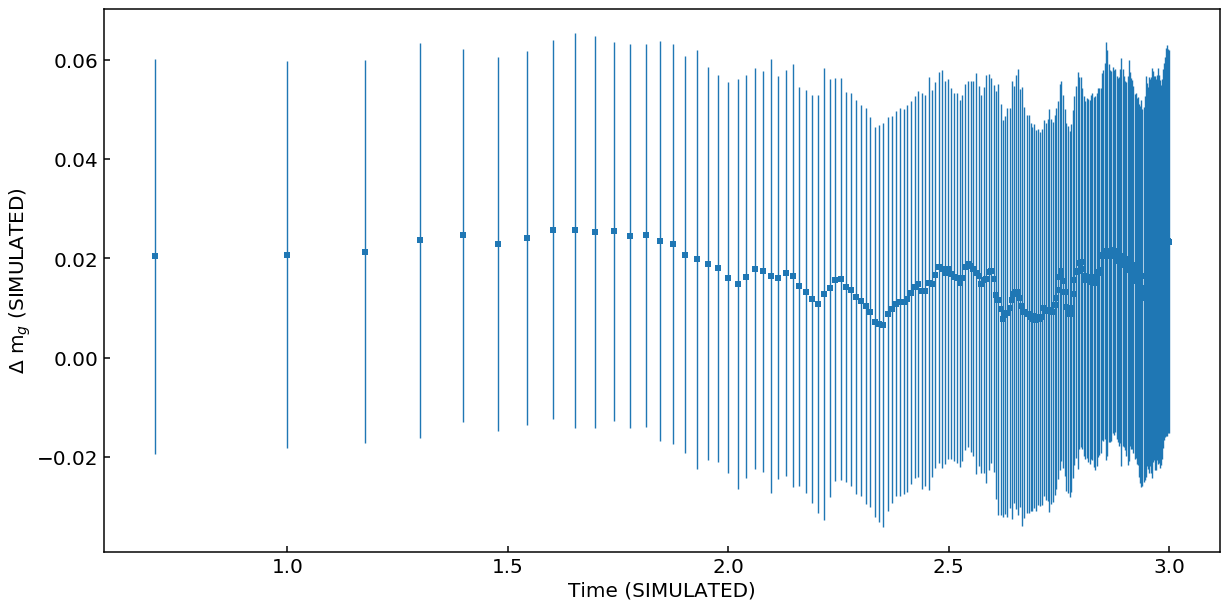

In [11]:
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, figsize=(20, 10))
    ax.tick_params(direction='in', length=6, width=1.5, labelsize=20)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    plt.errorbar(np.log10(t_examine), means, yerr=stands, fmt='s')    
    plt.ylabel('$\Delta$ m$_g$ (SIMULATED)', fontsize= 20)
    plt.xlabel('Time (SIMULATED)', fontsize= 20)
    
plt.savefig('Simulated_delta_g.pdf', bbox_inches='tight')    
plt.show()
